# Transacciones,
# Entradas y Salidas,
# y Transmisión

<a href="https://colab.research.google.com/github/ProfDoeg/Colegio_Invisible/blob/master/06_cuaderno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparar el Espacio (Prepare the Space)

In [16]:
! pip install eciespy eth_keys cryptos qrcode base58 
! git clone https://github.com/ProfDoeg/Colegio_Invisible.git

     |████████████████████████████████| 69 kB 3.9 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 2.0 MB 33.9 MB/s 
     |████████████████████████████████| 555 kB 72.0 MB/s 
     |████████████████████████████████| 104 kB 43.2 MB/s 
     |████████████████████████████████| 481 kB 55.1 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1230832 sha256=d1df807bd0543786b28deb7cee31fb15889d0f218ab756c053613c3830831395
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b556bba4f59
  Created wheel for qrcode: filename=qrcode-7.3.1-py3-none-any.whl size=40402 sha256=c9c57fa10d71ec403f2c8d158baae7ba491729fac032790486c6a260f21e7579
  Stored in directory: /root/.cache/pip/wheels/93/d7/39/a4111be2cfb8e679938aa671a37888b6afb1f9e7d748e94492
Successfully built cytoolz qrcode
Cloning into 'Colegio_Invisible'...
remote: Enumerating objects: 734, done.
remote: Counting

# Historias

<img src="https://github.com/ProfDoeg/Colegio_Invisible/raw/main/img/rump_final.jpeg" width="250"/>

***ilocución***: un acto de hablar o escribir que en sí mismo efectúa o constituye la acción intencionada
***

***illocution***: an act of speaking or writing which in itself effects or constitutes the intended action

# Crear Transacciones de Criptomoneda (Create Cryptocurrency Transactions)

## Esquema (Outline) 
Esta será una introducción a las transacciones de criptomonedas. Los participantes se conectan a la red del Colegio Invisible y publican su dirección criptográfica para recibir monedas. La transacción de financiación se construye, firma y transmite. Una vez que se confirma la transacción de financiación, los participantes devuelven las monedas construyendo, firmando y transmitiendo.
***
This will be an introduction to cryptocurrency transactions. Participants connect to the Invisible College network and post their crypto address to receive coins. The funding transaction is constructed, signed and broadcast. Once the funding transaction confirms, participants return the coins by constructing, signing, and broadcasting.
 
## Metas (Goals)
***
***
By the end of this notebook you should be able to:
***
Al final de este cuaderno, usted debería ser capaz de:
***
***
- Comprender la estructura de una transacción de Bitcoin/Dogecoin\
(Understand the structure of a Bitcoin/Dogecoin transaction)
- Importar las claves\
(Import Keys)
- Conectarse a Google Sheets compartidas\
(Connect to shared Google Sheets)
- Publicar la dirección\
(Post address)
- Consultar las otras direcciones\
(Query the addresses)
- Recibir criptomonedas\
(Receive crypto coins)
- Comprender UTXO las salidas de transacciones no gastadas\
(Understand UTXO Unspent Transaction Outputs)
- Comprender las entradas y salidas de transacciones\
(Understand Transaction Inputs and Outputs)
- Construir la transacción\
(Construct the transaction)
- Firmar transacción\
(Sign transaction)
- Convertir transacción a hexadecimal\
(Convert transaction to hex)
- Transmitir la transacción\
(Broadcast transaction)
- Supervisar la red para la confirmación\
(Monitor the network for confirmation)

# Importaciones y Definiciones (Imports and Definitions)

Crear funciones para importar claves y direcciones de criptomonedas.
***
Create functions for importing keys and cryptocurrency addresses.

In [17]:
import hashlib
import os
import getpass
import ecies
import eth_keys
import cryptos
import qrcode
import base58
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def import_privKey(privkey_filepath,password=None):
    if password==None:
        password = getpass.getpass("Input password for decrypting keyfile: ")
    password=password.encode()
    f=open(privkey_filepath,'rb')
    decrypted_bytes=ecies.aes_decrypt(key=hashlib.sha256(password).digest(),cipher_text=f.read())
    privKey=eth_keys.keys.PrivateKey(decrypted_bytes)
    return privKey

def import_pubKey(pubkey_filepath):
    f=open(pubkey_filepath,'rb')
    privKey=eth_keys.keys.PublicKey(f.read())
    return privKey

def import_addr(addr_filepath):
    return open(addr_filepath,'rb').read().decode()

# Comenzar con Claves Existentes (Start with Existing Keys)

Acceder a las claves generadas en el cuaderno 5
***
Access the keys generated in the cuaderno 5

## Comenzar con Claves en Google Drive (Start with Keys on Google Drive)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
! cp drive/MyDrive/cinv/llaves.zip llaves.zip 
! unzip llaves.zip

Archive:  llaves.zip
   creating: llaves/
 extracting: llaves/mi_addr.bin      
 extracting: llaves/mi_addr.png      
 extracting: llaves/mi_pub.bin       
 extracting: llaves/mi_prv.enc       


## Comenzar con Claves en la Disco Local
## (Start with Keys on Local Drive)

In [21]:
#from google.colab import files
#fu=files.upload();

In [22]:
#! unzip llaves.zip

In [23]:
#! ls llaves

# Import Private Key and Address

In [24]:
privKey=import_privKey('llaves/mi_prv.enc','')
addr=import_addr('llaves/mi_addr.bin')

In [25]:
addr

'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX'

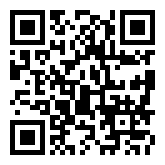

In [26]:
from IPython.display import Image
qr=Image('llaves/mi_addr.png')
display(qr)

# Connect to Colegio Message Spreadsheet

## Decrypt Credentials

$\color{white}{\text{c0leg101nv1s1ble}}$

Use la contraseña de arriba para descifrar las credenciales
***
Use password above to decrypt credentials


In [27]:
! python Colegio_Invisible/scripts/aes_decrypt.py c0leg101nv1s1ble Colegio_Invisible/secrets/client_secret.aes Colegio_Invisible/secrets/client_secret.json 

Éxito (Success): Colegio_Invisible/secrets/client_secret.aes decifrado con éxito (decryption complete)
Escrito a (Written to): Colegio_Invisible/secrets/client_secret.json


## Autenticar y Conectarse a la Google Sheet de Mensajes (Authenticate and Connect to Message Google Sheet)

Autenticarse usando credenciales descifradas para la API de Google Drive.\
Use la biblioteca `gspread` para leer y escribir en una hoja de cálculo compartida.
***
Authenticate using decrypted credentials for Google Drive API.\
Use `gspread` library to read and write to shared spreadsheet.

In [28]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('Colegio_Invisible/secrets/client_secret.json', scope)
client = gspread.authorize(creds)
sheets = client.open("signatures")

# Leer y Escribir en la Google Sheet de Mensajes (Read and Write to Messages Google Sheet)

## Leer Google Sheet (Read Google Sheet)

In [29]:
sheets.worksheets()

[<Worksheet 'Roster' id:0>,
 <Worksheet 'OpenMessage' id:2092809244>,
 <Worksheet 'CipherMessage' id:549527758>,
 <Worksheet 'SignCipherMessage' id:858983463>,
 <Worksheet 'Addresses' id:475665302>,
 <Worksheet 'Test' id:2104752728>]

In [30]:
sheet4=sheets.worksheets()[4]
sheet4.row_values(1)

['name', 'address']

In [31]:
#sheet4.clear()
#sheet4.append_row(["name", "address"])

## Ingresar el Nombre (Input Name)

In [32]:
my_name=input('input name')

input nameDrDoeg


## Leer Nombres Publicados (Read Posted Names)

In [33]:
peeps=sheet4.col_values(1)[1:]
peeps

['DrDoeg']

## Escribir en la Google Sheet para Publicar Nombre (Write to Google Sheet to Publish Name)

Si el nombre está en la lista, escriba la dirección en la celda correspondiente de la hoja\
Si el nombre no está presente, agregue el nombre y la dirección a la hoja
***
If the name is in the list then write address to the appropriate cell of sheet\
If name is not present append name and address to sheet

In [34]:
if not (my_name in peeps) :
  sheet4.append_row([my_name,addr])
else:
  sheet4.update_cell(row=peeps.index(my_name)+2,col=2,value=addr)

## Leer Direcciones (Read Addresses)

In [35]:
import pandas as pd

dataframe4 = pd.DataFrame(sheet4.get_all_records())
dataframe4

,name,address
0,DrDoeg,D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX


## Construir Lista de los Direcciones de Destinatario (Construct List of Recipient Addresses) 

In [36]:
addresses=dataframe4.address.tolist()
addresses

['D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX']

# Enviar Direcciones de Criptomonedas con Transacción de Financiación (Send Addresses Cryptocurrency with Funding Transaction)

## Importar 'cryptos' y Crear un Objeto de Dogecoin (Import `cryptos` and Create Dogecoin Object)

In [37]:
import cryptos

In [38]:
doge=cryptos.Doge()

## Las Entradas (Inputs)

### Identificar la Dirección de Financiación (Identify Funding Address)

In [39]:
banco=addresses[0]
banco

'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX'

### Determinar las Entradas de UTXO (Determine UTXO Inputs)

***
***
Los UTXO son salidas de transacciones no gastadas. Comenzamos revisando la cadena de bloques para identificar las monedas que la dirección de financiación ha recibido pero que aún no ha gastado. Estos son UTXO.
***
UTXOs are Unspent Transaction Outputs. We start by checking the blockchain to identify coins the funding address has received but has not yet spent. These are UTXOs. 
***
***

Cada UTXO contiene (each UTXO contains):
- valor (value)
- transacción (transaction)
  - hash (hash)
  - índice (index)

In [40]:
#UTXOS
unspents=doge.unspent(banco)
unspents

[{'output': 'b40389d5ebbef896e78570a83e646e922522f445b10f532e53b45ea4a054caf0:0',
  'value': 200000000},
 {'output': 'b40389d5ebbef896e78570a83e646e922522f445b10f532e53b45ea4a054caf0:6',
  'value': 6600000000}]

### Satoshis

El valor se informa en unidades de Satoshis/Dogetoshis. Un Satoshi es un $\frac{1}{100,000,000}$ de una moneda.
***
The value is reported in units of Satoshis/Dogetoshis. A Satoshi is $\frac{1}{100,000,000}$ of a coin.

### Sumar Salidas No Gastadas (Sum Unspent Outputs)

In [41]:
unspent_total=sum([unspent['value'] for unspent in unspents])
unspent_total

6800000000

## Salidas (Outputs)

### Calcular Valores de Salida (Calculate Output Values)

- `gift`: es la cantidad entregada a cada participante\
(the amount given to each participant)
- `gift_total`: la cantidad total entregada\
(the total amount given)
- `mining_fee`: cantidad entregada a los mineros\
(amount given to miners)
- `change`: cantidad sobrante que el remitente enviará a una dirección de cambio\
(the left over amount that the sender will send to a change address)

In [50]:
gift=10_00_000_000
gift_total = gift * len(addresses)
mining_fee = 2_00_000_000
change = unspent_total - gift_total - mining_fee 

### Construir Lista de Salidas (Construct Output List)
***
***
Crear salidas que incluyan:
***
Create outputs including:
***
***
- `gift` regalo a cada participante\
 (`gift` to each participant)
- `change` enviado de vuelta a `banco` direccion\
(`change` sent back to `banco` address)

In [51]:
outputs=[{'value': gift, 'address': address} for address in addresses]
outputs.append({'value': change, 'address': banco})
outputs

[{'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX', 'value': 1000000000},
 {'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX', 'value': 5700000000}]


## Hacer Transacción de Financiamiento (Make Funding Transaction)

In [52]:
fund_txn=doge.mktx(unspents,outputs )
fund_txn

{'ins': [{'amount': 200000000,
   'outpoint': {'hash': 'b40389d5ebbef896e78570a83e646e922522f445b10f532e53b45ea4a054caf0',
    'index': 0},
   'script': '',
   'sequence': 4294967295},
  {'amount': 6600000000,
   'outpoint': {'hash': 'b40389d5ebbef896e78570a83e646e922522f445b10f532e53b45ea4a054caf0',
    'index': 6},
   'script': '',
   'sequence': 4294967295}],
 'locktime': 0,
 'outs': [{'script': '76a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac',
   'value': 1000000000},
  {'script': '76a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac',
   'value': 5700000000}],
 'version': 1}

## Firmar Transacción de Financiamiento (Sign Funding Transaction)

In [53]:
doge.signall(fund_txn,privKey.to_hex()[2:])

'0100000002f0ca54a0a45eb4532e530fb145f42225926e643ea87085e796f8beebd58903b4000000008b483045022100c0292317f2bd31f41c73d07a06b68c24d5acb9cc9f8ede5262facd6d2e3b41e8022054a4fe08d1b81b03e1cc3ac21f35b85f8376ef6c2547d0d29cb828c216e253450141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5fffffffff0ca54a0a45eb4532e530fb145f42225926e643ea87085e796f8beebd58903b4060000008b483045022100d7b03a60fc7ff676860a66379b564d9a77e1266ea1c5f740700bf183d27129ae022071910f9219c5857c00b9b89048552d21ce2149edc77c8da31a950ee0d854b9450141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5ffffffff0200ca9a3b000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac0019bf53010000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac00000000'

In [54]:
fund_txn

{'ins': [{'amount': 200000000,
   'outpoint': {'hash': 'b40389d5ebbef896e78570a83e646e922522f445b10f532e53b45ea4a054caf0',
    'index': 0},
   'script': '483045022100c0292317f2bd31f41c73d07a06b68c24d5acb9cc9f8ede5262facd6d2e3b41e8022054a4fe08d1b81b03e1cc3ac21f35b85f8376ef6c2547d0d29cb828c216e253450141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5',
   'sequence': 4294967295},
  {'amount': 6600000000,
   'outpoint': {'hash': 'b40389d5ebbef896e78570a83e646e922522f445b10f532e53b45ea4a054caf0',
    'index': 6},
   'script': '483045022100d7b03a60fc7ff676860a66379b564d9a77e1266ea1c5f740700bf183d27129ae022071910f9219c5857c00b9b89048552d21ce2149edc77c8da31a950ee0d854b9450141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5',
   'sequence': 4294967295}],
 'locktime': 0,
 'outs': [{'script': '76a914144739367df0ff8d1c61d03704298d49cf9

In [55]:
fund_txn_hex=cryptos.serialize(fund_txn)
fund_txn_hex

'0100000002f0ca54a0a45eb4532e530fb145f42225926e643ea87085e796f8beebd58903b4000000008b483045022100c0292317f2bd31f41c73d07a06b68c24d5acb9cc9f8ede5262facd6d2e3b41e8022054a4fe08d1b81b03e1cc3ac21f35b85f8376ef6c2547d0d29cb828c216e253450141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5fffffffff0ca54a0a45eb4532e530fb145f42225926e643ea87085e796f8beebd58903b4060000008b483045022100d7b03a60fc7ff676860a66379b564d9a77e1266ea1c5f740700bf183d27129ae022071910f9219c5857c00b9b89048552d21ce2149edc77c8da31a950ee0d854b9450141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5ffffffff0200ca9a3b000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac0019bf53010000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac00000000'

## Comprobar el Tamaño en Kilobytes de la Transacción (Check Kilobyte Size of Transaction)

https://chain.so/DOGE

In [56]:
kb=len(fund_txn_hex)/2000
kb

0.438

In [57]:
mining_fee/1E8/kb

2.2831050228310503

## Transmitir la Transacción (Broadcast Transaction)

In [58]:
broadcast_fund_txn=doge.pushtx(fund_txn_hex)
broadcast_fund_txn

{'data': {'network': 'DOGE',
  'txid': '5f656cdf221788c5b871d620fddbf36837ccef9a0f99bff97c05b470e9ae86d2'},
 'status': 'success'}

## Inspeccionar la Transacción (Inspect Transaction)

In [59]:
inspect_fund_txn=doge.fetchtx( broadcast_fund_txn['data']['txid'])
inspect_fund_txn

{'blockhash': None,
 'confirmations': 0,
 'inputs': [{'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX',
   'from_output': {'output_no': 0,
    'txid': 'b40389d5ebbef896e78570a83e646e922522f445b10f532e53b45ea4a054caf0'},
   'input_no': 0,
   'script': '3045022100c0292317f2bd31f41c73d07a06b68c24d5acb9cc9f8ede5262facd6d2e3b41e8022054a4fe08d1b81b03e1cc3ac21f35b85f8376ef6c2547d0d29cb828c216e2534501 047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5',
   'sequence': 4294967295,
   'type': 'pubkeyhash',
   'value': '2.00000000',
   'witness': None},
  {'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX',
   'from_output': {'output_no': 6,
    'txid': 'b40389d5ebbef896e78570a83e646e922522f445b10f532e53b45ea4a054caf0'},
   'input_no': 1,
   'script': '3045022100d7b03a60fc7ff676860a66379b564d9a77e1266ea1c5f740700bf183d27129ae022071910f9219c5857c00b9b89048552d21ce2149edc77c8da31a950ee0d854b94501 047c88e9a4df6e9f45656c10bf6

# Devolver la Criptomoneda (Return Coins)

## Construir la Transacción de Devolver (Construct Return Transaction)

### Entradas (Inputs)

In [60]:
mi_unspents=doge.unspent(addr)
mi_unspents


[{'output': '5f656cdf221788c5b871d620fddbf36837ccef9a0f99bff97c05b470e9ae86d2:0',
  'value': 1000000000},
 {'output': '5f656cdf221788c5b871d620fddbf36837ccef9a0f99bff97c05b470e9ae86d2:1',
  'value': 5700000000}]

In [61]:
mi_unspent_total=sum([unspent['value'] for unspent in mi_unspents])
mi_unspent_total

6700000000

### Salidas (Outputs)

In [62]:
mi_mining_fee = 1_00_000_000
disponible = mi_unspent_total - mi_mining_fee
disponible

6600000000

In [63]:
destinos=[{'value': disponible, 'address': banco} ]
destinos

[{'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX', 'value': 6600000000}]

## Pare !! Ladrón !! (Stop Thief)

Para robar las monedas en lugar de devolverlas, ejecute las celdas **`Ladrón`** al final del cuaderno.
***
To steal the coins instead of returning them, run the **`Ladrón`** cells at the end of the notebook.

### Construcción (Constuction)

In [72]:
volver_txn=doge.mktx(mi_unspents, destinos)
volver_txn

{'ins': [{'amount': 1000000000,
   'outpoint': {'hash': '5f656cdf221788c5b871d620fddbf36837ccef9a0f99bff97c05b470e9ae86d2',
    'index': 0},
   'script': '',
   'sequence': 4294967295},
  {'amount': 5700000000,
   'outpoint': {'hash': '5f656cdf221788c5b871d620fddbf36837ccef9a0f99bff97c05b470e9ae86d2',
    'index': 1},
   'script': '',
   'sequence': 4294967295}],
 'locktime': 0,
 'outs': [{'script': '76a914a8a2e5833974f40b826c0df633e2f131286d6ee188ac',
   'value': 6600000000}],
 'version': 1}

## Firmar y Serializar (Sign and Serialize)

In [73]:
doge.signall(volver_txn,privKey.to_hex()[2:]);

In [74]:
volver_txn_hex=cryptos.serialize(volver_txn)
volver_txn_hex

'0100000002d286aee970b4057cf9bf990f9aefcc3768f3dbfd20d671b8c5881722df6c655f000000008a47304402205f109040569820ebd288c47e3bfe86b3ff2f79357c39a6261baeb31d4338954002204127f6aa7a7f0db347b8309bfdccb389d095b0001ca59027b3551940221be5b70141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5ffffffffd286aee970b4057cf9bf990f9aefcc3768f3dbfd20d671b8c5881722df6c655f010000008a473044022022f9b090acebefa0a22c733f3230aa542ee10df93d19d49d7868155214e1f2b40220719620c05ffcb6a0aadd59869099e02ded1195ea413b0b8db77e6e2b9144b74d0141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5ffffffff0100026489010000001976a914a8a2e5833974f40b826c0df633e2f131286d6ee188ac00000000'

## Transmisión (Broadcast)

In [75]:
broadcast_volver_txn=doge.pushtx(volver_txn_hex)
broadcast_volver_txn

{'data': {'network': 'DOGE',
  'txid': '9bdf9d2d157368e01bbf1737c9bb73e957ea6c41f4d17c0fec187f3bf7f76bd2'},
 'status': 'success'}

## Supervisar la Red (Monitor the Network)

In [76]:
inspect_volver_txn=doge.fetchtx( broadcast_volver_txn['data']['txid'])
inspect_volver_txn

{'blockhash': None,
 'confirmations': 0,
 'inputs': [{'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX',
   'from_output': {'output_no': 0,
    'txid': '5f656cdf221788c5b871d620fddbf36837ccef9a0f99bff97c05b470e9ae86d2'},
   'input_no': 0,
   'script': '304402205f109040569820ebd288c47e3bfe86b3ff2f79357c39a6261baeb31d4338954002204127f6aa7a7f0db347b8309bfdccb389d095b0001ca59027b3551940221be5b701 047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5',
   'sequence': 4294967295,
   'type': 'pubkeyhash',
   'value': '10.00000000',
   'witness': None},
  {'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX',
   'from_output': {'output_no': 1,
    'txid': '5f656cdf221788c5b871d620fddbf36837ccef9a0f99bff97c05b470e9ae86d2'},
   'input_no': 1,
   'script': '3044022022f9b090acebefa0a22c733f3230aa542ee10df93d19d49d7868155214e1f2b40220719620c05ffcb6a0aadd59869099e02ded1195ea413b0b8db77e6e2b9144b74d01 047c88e9a4df6e9f45656c10bf66f2

****
****

# Ladrón 

***
***

In [64]:
!pip install pyzbar[scripts]
!apt install libzbar0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libzbar0 is already the newest version (0.10+doc-10.1build2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsigh

In [65]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


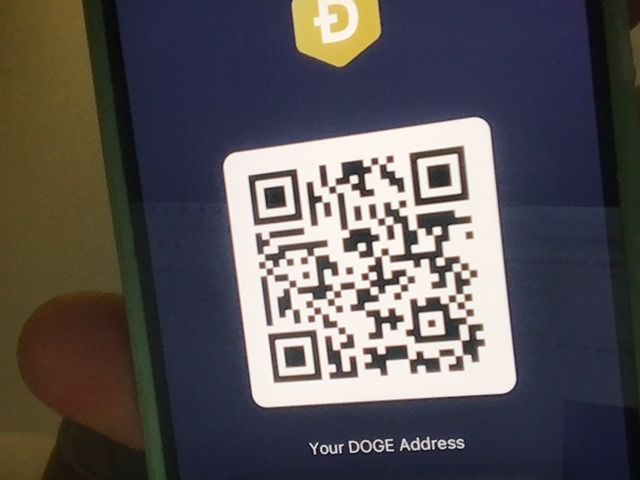

In [66]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [67]:
from pyzbar.pyzbar import decode
from PIL import Image
scan=decode(Image.open('photo.jpg'))
scan

[Decoded(data=b'DLWmCjcZRnGCpaWZxD2uZZ8Tad1oKAhBwa', type='QRCODE', rect=Rect(left=247, top=144, width=240, height=239), polygon=[Point(x=247, y=174), Point(x=273, y=383), Point(x=487, y=368), Point(x=465, y=144)])]

In [68]:
scan[0]

Decoded(data=b'DLWmCjcZRnGCpaWZxD2uZZ8Tad1oKAhBwa', type='QRCODE', rect=Rect(left=247, top=144, width=240, height=239), polygon=[Point(x=247, y=174), Point(x=273, y=383), Point(x=487, y=368), Point(x=465, y=144)])

In [69]:
thief=scan[0].data.decode().split(':')[-1]
thief

'DLWmCjcZRnGCpaWZxD2uZZ8Tad1oKAhBwa'

In [71]:
destinos=[{'value': disponible, 'address': thief} ]
destinos

[{'address': 'DLWmCjcZRnGCpaWZxD2uZZ8Tad1oKAhBwa', 'value': 6600000000}]